# Cap & Floor SDK - Cashflows Analysis


This notebook in the Cap & Floor SDK series builds upon the Fundamentals and Greeks Templates and demonstrates advanced **Cashflows analysis** within the **LSEG Financial Analytics SDK**. 

**You will be able to:**
- Define Cap/Floor instruments with advanced set of arguments
- Estimate future Cap/Floor CashFlows
- Analyze detailed valuation metrics and Cashflows 
- Visualize forward rates curve for further analysis


## Imports


Import the following necessary modules:

- `lseg_analytics.instruments.cap_floor` - for CapFloor instruments definitions and analytics

In [1]:
from lseg_analytics.instruments import cap_floor as cf

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.dates as mdates

## Data Preparation

To define a Cap/Floor instrument you need to follow a structured 3-step process:

1. **CapFloor Definition** - Specify basic cap/floor parameters (strike, dates, notional, index)
2. **CapFloor Instrument Definition** - Create the instrument object
3. **Pricing Preferences** - Configure pricing parameters, optional


In [2]:
# 1. Define the cap instrument
cap_definition = cf.IPACapFloorDefinition(
    buy_sell = cf.IPABuySellEnum.BUY.value,                                   # Buy cap protection
    cap_strike_percent = 2.0,                                                 # 2% strike rate
    start_date = dt.datetime.strptime("2025-01-01", "%Y-%m-%d"),              # Start date
    end_date = dt.datetime.strptime("2030-01-01", "%Y-%m-%d"),                # Maturity date
    notional_amount = 1_000_000,                                              # $1M notional
    notional_ccy = "USD",                                                     # USD currency
    index_name = "SOFR",                                                      # SOFR index
    index_tenor = "ON",
    interest_payment_frequency = cf.IndexResetFrequencyEnum.QUARTERLY.value,  # Quarterly payments
)

cap_instrument = cf.IPACapFloorDefinitionInstrument(definition = cap_definition)
print("Instrument definition created")

# 2. Configure pricing parameters
pricing_params = cf.CapFloorPricingParameters(
    valuation_date = dt.datetime.strptime("2025-07-18", "%Y-%m-%d"),                
)
print("Pricing parameters configured")

Instrument definition created
Pricing parameters configured


## Request Execution

In [3]:
#  Execute the calculation using the price() function
# The 'definitions' parameter accepts a list of instruments definitions for batch processing

response = cf.price(
    definitions = [cap_instrument],
    pricing_preferences = pricing_params
)

print("Pricing execution completed")

Pricing execution completed


## Results Display

#### Valuation Data Overview

- **Market value & Premium**: Overall deal-level values such as market value and premium.
- **Caplet Market Values**: Individual market values for each caplet in the structure.
- **Cap/Floor premium schedule**: A premium payments with corresponding dates.
 

##### Cap Market value & Premium

In [4]:
# Extract and filter Cap/Floor level valuation data
valuation = response.data.analytics[0].valuation
cap_valuation_data = {k: v for k, v in valuation.items() if not isinstance(v, (list, dict))}

# Convert to DataFrame
df_cap_valuation = pd.DataFrame(list(cap_valuation_data.items()), columns=["Fields", "Value"])

display(df_cap_valuation)

,Fields,Value
0,marketValueInDealCcy,70486.889740
1,premiumPercent,7.048689
2,premiumBp,704.868897


##### Caplets Market values

In [5]:
# Extract caplets market values directly from response
caplets_values = valuation["capletsMarketValuesInDealCcyArray"]
df_caplets_values = pd.DataFrame(caplets_values, columns=["Caplets Market Value"])

# Convert caplets values to DataFrame
display(df_caplets_values)

,Caplets Market Value
0,0.000000
1,0.000000
2,5904.480831
3,5371.717187
4,4463.200739
5,3975.994119
6,3507.016618
7,3353.273550
8,3002.286115
9,3176.746212


##### Cap/Floor Premium schedule

In [6]:
# Extract premium schedule directly from response
premium_schedule = valuation["capFloorPremiumSchedule"]
df_premium_schedule = pd.DataFrame(premium_schedule)

# Convert premium schedule to DataFrame
display(df_premium_schedule)

,paymentDate,amount
0,2025-10-01,3528.630590
1,2026-01-02,4375.501932
2,2026-04-01,4187.308300
3,2026-07-01,4281.405116
4,2026-10-01,4328.453524
5,2027-01-04,4469.598748
6,2027-04-01,4093.211485
7,2027-07-01,4281.405116
8,2027-10-01,4328.453524
9,2028-01-03,4422.550340


#### Pricing Analysis

 - **Cap Pricing Metrics**: Key deal-level values such as strike rate, ATM strike, implied volatility, and spread equivalent.


##### Cap Pricing Metrics

In [7]:
# Extract pricing analysis from response
pricing_analysis = response.data.analytics[0].pricing_analysis

# Create summary metrics DataFrame
df_pricing_metrics = pd.DataFrame([
    ["Cap Strike (%)", pricing_analysis["capStrikePercent"]],
    ["ATM Strike (%)", pricing_analysis["atmStrikePercent"]],
    ["Implied Volatility (%)", pricing_analysis["impliedVolatilityPercent"]],
    ["Implied Volatility (bp)", pricing_analysis["impliedVolatilityBp"]],
    ["Spread Equivalent (bp)", pricing_analysis["spreadEquivalentBp"]],
    ["Valuation Date", pricing_analysis["valuationDate"]],
    ["Market Data Date", pricing_analysis["marketDataDate"]]
], columns=["Fields", "Value"])

# Convert pricing metrics to DataFrame
display(df_pricing_metrics)


,Fields,Value
0,Cap Strike (%),2.0
1,ATM Strike (%),3.526889
2,Implied Volatility (%),39.107759
3,Implied Volatility (bp),101.591207
4,Spread Equivalent (bp),169.374268
5,Valuation Date,2025-07-18T00:00:00Z
6,Market Data Date,2025-07-18T00:00:00Z


#### Caplets Cashflows

This cell extracts structured caplet cashflow arrays from the `cashflows` object and loads them into a pandas DataFrame. 


In [8]:
# Extract cashflows from response
cashflows = response.data.analytics[0].cashflows

# Extract caplets cashflow data directly from response
caplets_cashflow_data = {
    "Start_Date": cashflows["capletsStartDatesArray"],
    "End_Date": cashflows["capletsEndDatesArray"],
    "Strike_Percent": cashflows["capletsStrikePercentArray"],
    "Forward_Rate_Percent": cashflows["capletsForwardRatePercentArray"],
    "Amortization": cashflows["amortizationAmountsInDealCcyArray"],
    "Remaining_Notional": cashflows["capletsRemainingNotionalAmountsInDealCcyArray"],
    "Caplets_Payoff_Amount": cashflows["capletsPayoffAmountsInDealCcyArray"]
}

df_caplets_cashflows = pd.DataFrame(caplets_cashflow_data)

# Convert caplets cashflows to DataFrame
display(df_caplets_cashflows)

,Start_Date,End_Date,Strike_Percent,Forward_Rate_Percent,Amortization,Remaining_Notional,Caplets_Payoff_Amount
0,2025-01-02,2025-04-01,2.0,4.331236,0.0,1000000.0,5763.333333
1,2025-04-01,2025-07-01,2.0,4.321978,0.0,1000000.0,5869.444444
2,2025-07-01,2025-10-01,2.0,4.331346,0.0,1000000.0,0.000000
3,2025-10-01,2026-01-02,2.0,4.120169,0.0,1000000.0,0.000000
4,2026-01-02,2026-04-01,2.0,3.852595,0.0,1000000.0,0.000000
5,2026-04-01,2026-07-01,2.0,3.607420,0.0,1000000.0,0.000000
6,2026-07-01,2026-10-01,2.0,3.371131,0.0,1000000.0,0.000000
7,2026-10-01,2027-01-04,2.0,3.231424,0.0,1000000.0,0.000000
8,2027-01-04,2027-04-01,2.0,3.178312,0.0,1000000.0,0.000000
9,2027-04-01,2027-07-01,2.0,3.180349,0.0,1000000.0,0.000000


##### Caplet Forward Rate Curve

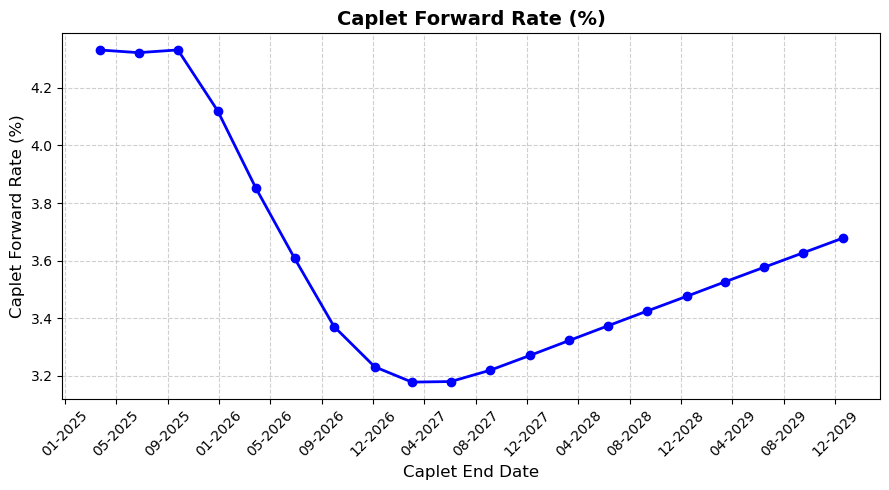

In [9]:
# Extract end dates and forward rates from the cashflows dictionary (optimized)
end_dates = pd.to_datetime(cashflows["capletsEndDatesArray"])
forward_rates = cashflows["capletsForwardRatePercentArray"]

# Plot
plt.figure(figsize=(9, 5))
plt.plot(end_dates, forward_rates, marker='o', linestyle='-', color='blue', linewidth=2, markersize=6)

# Enhancements
plt.title("Caplet Forward Rate (%)", fontsize=14, fontweight='bold')
plt.xlabel("Caplet End Date", fontsize=12)
plt.ylabel("Caplet Forward Rate (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### Cashflows schedule

In [10]:
# Simple extraction and flattening of cashFlows
cf = response.data.analytics[0].cashflows["cashFlows"]
df_cap_cashflows = pd.json_normalize(cf, 'payments', ['instrumentType'])

# Convert cap cashflows to DataFrame
display(df_cap_cashflows)

,date,amount,currency,event,occurence,remainingNotional,indexFixings,instrumentType
0,2025-01-01,NaN,USD,Premium,Historical,NaN,NaN,Option
1,2025-04-01,5763.333333,USD,Payoff,Historical,1000000.0,"[{'accrualStartDate': '2025-01-02', 'accrualEn...",Cap
2,2025-07-01,5869.444444,USD,Payoff,Historical,1000000.0,"[{'accrualStartDate': '2025-04-01', 'accrualEn...",Cap
3,2025-10-01,5957.884120,USD,Payoff,Projected,1000000.0,"[{'accrualStartDate': '2025-07-01', 'accrualEn...",Cap
4,2026-01-02,5477.103457,USD,Payoff,Projected,1000000.0,"[{'accrualStartDate': '2025-10-01', 'accrualEn...",Cap
5,2026-04-01,4580.027171,USD,Payoff,Projected,1000000.0,"[{'accrualStartDate': '2026-01-02', 'accrualEn...",Cap
6,2026-07-01,4063.200278,USD,Payoff,Projected,1000000.0,"[{'accrualStartDate': '2026-04-01', 'accrualEn...",Cap
7,2026-10-01,3504.001189,USD,Payoff,Projected,1000000.0,"[{'accrualStartDate': '2026-07-01', 'accrualEn...",Cap
8,2027-01-04,3249.590874,USD,Payoff,Projected,1000000.0,"[{'accrualStartDate': '2026-10-01', 'accrualEn...",Cap
9,2027-04-01,2847.587623,USD,Payoff,Projected,1000000.0,"[{'accrualStartDate': '2027-01-04', 'accrualEn...",Cap


##### Visualize Cashflows

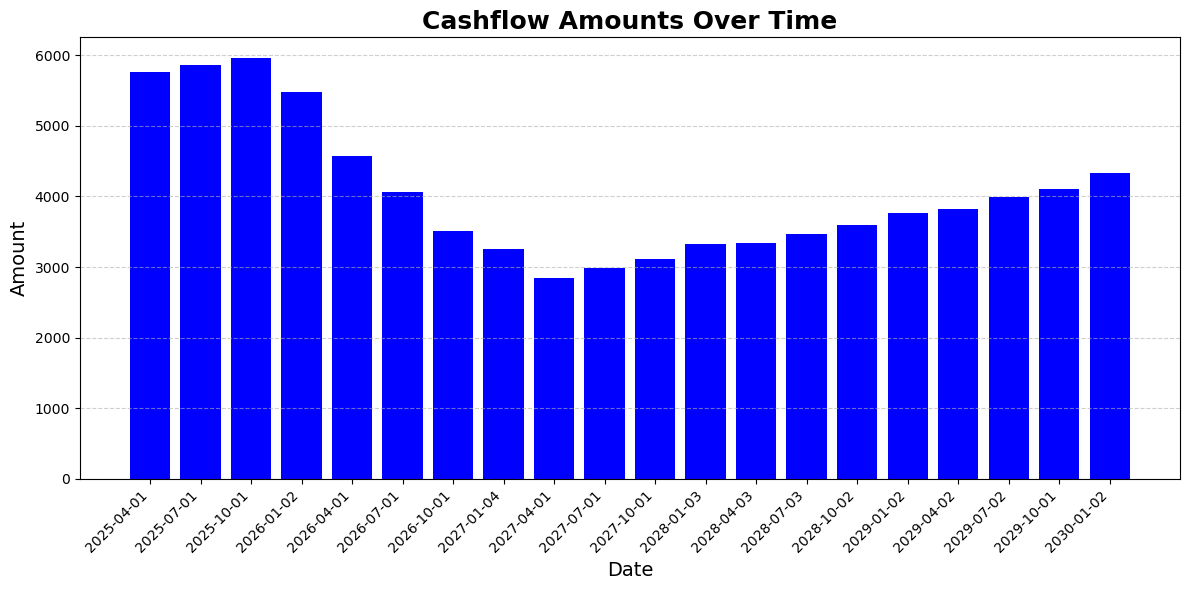

In [11]:
# Filter and prepare data
df_Cashflows = df_cap_cashflows.dropna(subset=['amount']).copy()
df_Cashflows['date'] = pd.to_datetime(df_Cashflows['date'])

# Plot df_Cashflows
plt.figure(figsize=(12, 6))
plt.bar(df_Cashflows['date'].dt.strftime('%Y-%m-%d'), df_Cashflows['amount'], width=0.8, color='blue')

plt.title('Cashflow Amounts Over Time', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Amount', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
